In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.preprocessing import LabelEncoder, StandardScaler

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv("/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv")
df.info()
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [3]:
df.drop(['Surname', 'Gender', 'RowNumber', 'CustomerId', 'Card Type'], axis= 1, inplace= True)
df

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
0,619,France,42,2,0.00,1,1,1,101348.88,1,1,2,464
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0,1,3,456
2,502,France,42,8,159660.80,3,1,0,113931.57,1,1,3,377
3,699,France,39,1,0.00,2,0,0,93826.63,0,0,5,350
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0,0,5,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,39,5,0.00,2,1,0,96270.64,0,0,1,300
9996,516,France,35,10,57369.61,1,1,1,101699.77,0,0,5,771
9997,709,France,36,7,0.00,1,0,1,42085.58,1,1,3,564
9998,772,Germany,42,3,75075.31,2,1,0,92888.52,1,1,2,339


In [4]:
palette = {"Germany":"#F0E100", "France": "#01295F", "Spain": "#F17105"}

palette_df = pd.DataFrame(palette.items(), columns= ['Geography', 'Color'])

palette_df

,Geography,Color
0,Germany,#F0E100
1,France,#01295F
2,Spain,#F17105


In [5]:
customersa = pd.DataFrame(df['Geography'].value_counts(normalize= False))
customersa

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [6]:
customersb = customersa.reset_index().rename(columns= {'index':'Geography','Count':'Geography'})
customersb

,Geography,count
0,France,5014
1,Germany,2509
2,Spain,2477


In [7]:
customers = pd.merge(customersb, palette_df, on=['Geography'], how='outer')

In [8]:
customers

,Geography,count,Color
0,France,5014,#01295F
1,Germany,2509,#F0E100
2,Spain,2477,#F17105


In [9]:
fig = go.Figure(data=[go.Pie(labels= customers['Geography'], values= customers['count'], textinfo= 'label',
                             name= 'Customers Geographical Locations', marker_colors= customers['Color'], hole= 0.5)])
fig.show()

In [10]:
# Churners and Non-Churners based on their country
churners = df[df['Exited'] == 1]
nonchurners = df[df['Exited'] == 0]

print(churners)
print(nonchurners)

      CreditScore Geography  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619    France   42       2       0.00              1          1   
2             502    France   42       8  159660.80              3          1   
5             645     Spain   44       8  113755.78              2          1   
7             376   Germany   29       4  115046.74              4          1   
16            653   Germany   58       1  132602.88              1          1   
...           ...       ...  ...     ...        ...            ...        ...   
9981          498   Germany   42       3  152039.70              1          1   
9982          655   Germany   46       7  137145.12              1          1   
9991          597    France   53       4   88381.21              1          1   
9997          709    France   36       7       0.00              1          0   
9998          772   Germany   42       3   75075.31              2          1   

      IsActiveMember  Estim

In [11]:
churners_counta = pd.DataFrame(churners['Geography'].value_counts(normalize= False))
churners_counta = churners_counta.reset_index().rename(columns= {'index':'Geography','Count':'Geography'})
churners_count = pd.merge(churners_counta, palette_df, on=['Geography'], how='outer')

churners_count

,Geography,count,Color
0,France,811,#01295F
1,Germany,814,#F0E100
2,Spain,413,#F17105


In [12]:
nonchurners_counta = pd.DataFrame(nonchurners['Geography'].value_counts(normalize= False))
nonchurners_counta = nonchurners_counta.reset_index().rename(columns= {'index':'Geography','Count':'Geography'})
nonchurners_count = pd.merge(nonchurners_counta, palette_df, on=['Geography'], how='outer')

nonchurners_count

,Geography,count,Color
0,France,4203,#01295F
1,Germany,1695,#F0E100
2,Spain,2064,#F17105


In [13]:
fig = make_subplots(rows= 1, cols= 2, specs= [[{'type':'pie'},{'type':'pie'}]], subplot_titles= ("Churners by Location",
                                                                                                "Non-Churners by Location"))

fig.add_trace(go.Pie(labels= churners_count['Geography'], values= churners_count['count'], textinfo= 'label',
                     name= "Churners Geographical Locations", marker_colors= churners_count['Color'], hole= 0.5), 1, 1)

fig.add_trace(go.Pie(labels= nonchurners_count['Geography'], values= nonchurners_count['count'], textinfo= 'label',
                     name= "Non-Churners Geographical Locations", marker_colors= nonchurners_count['Color'], hole= 0.5), 1, 2)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

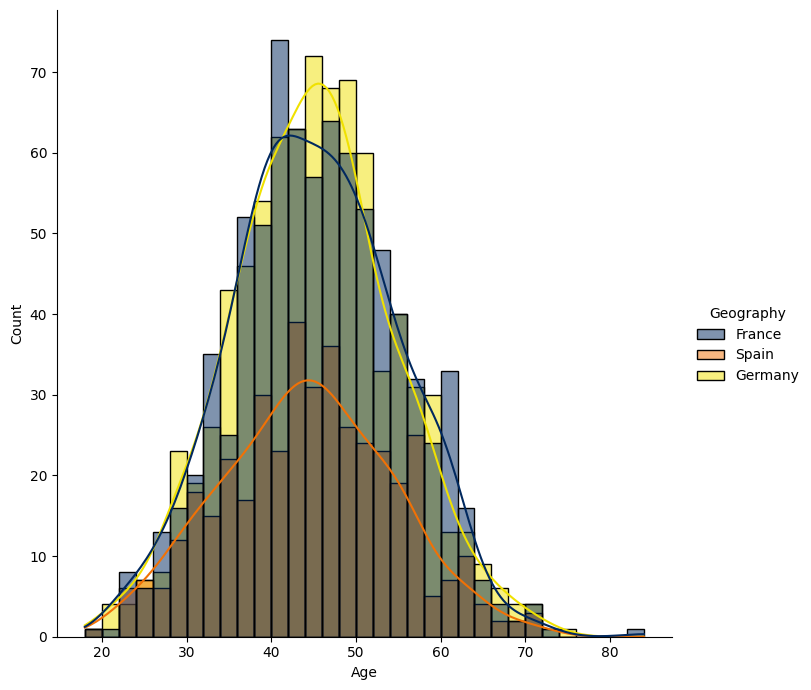

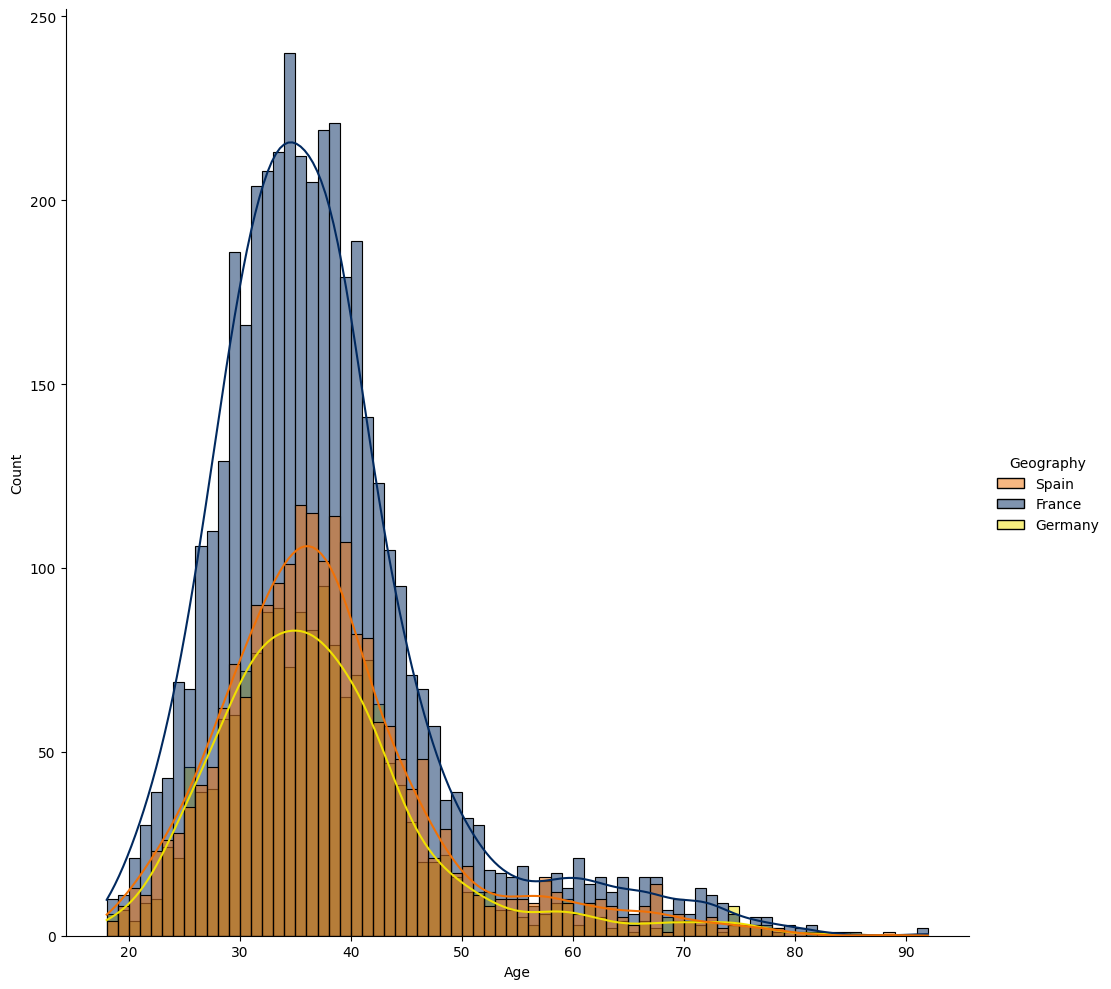

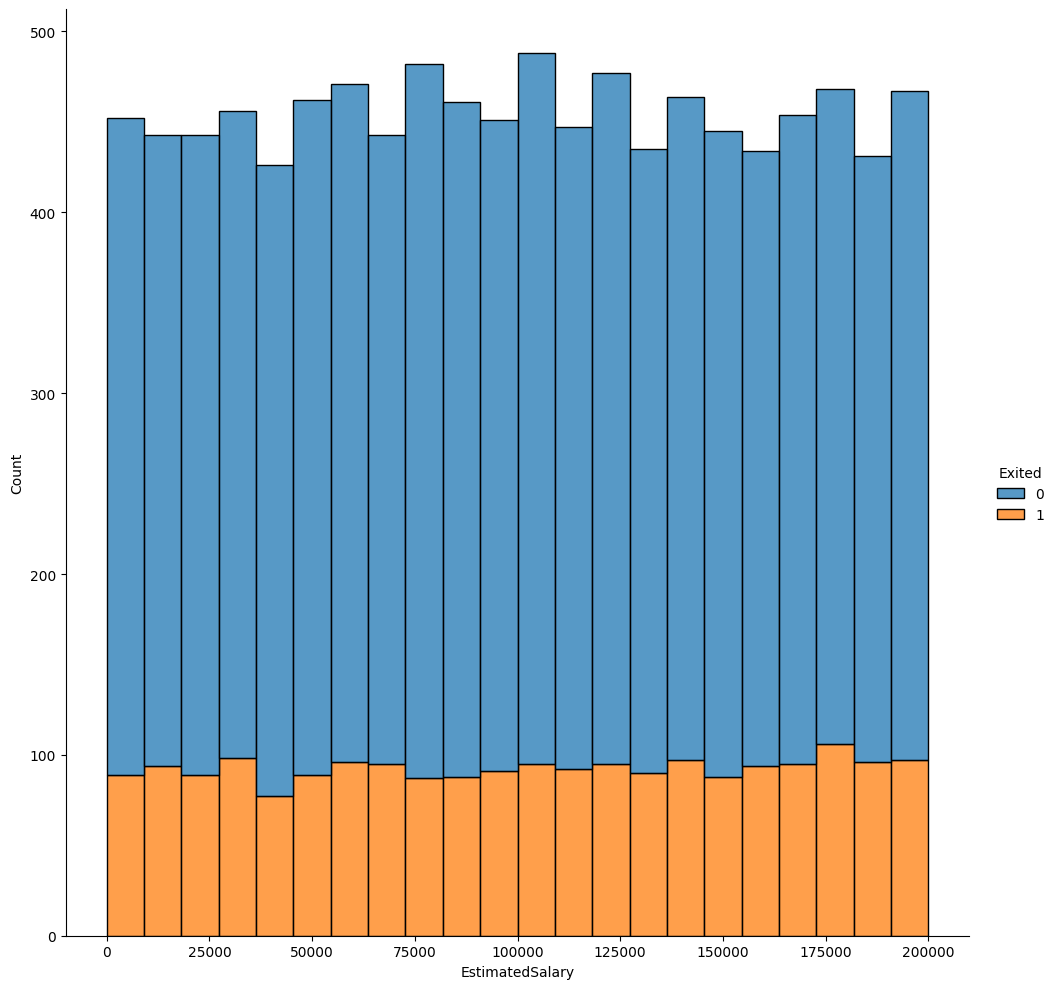

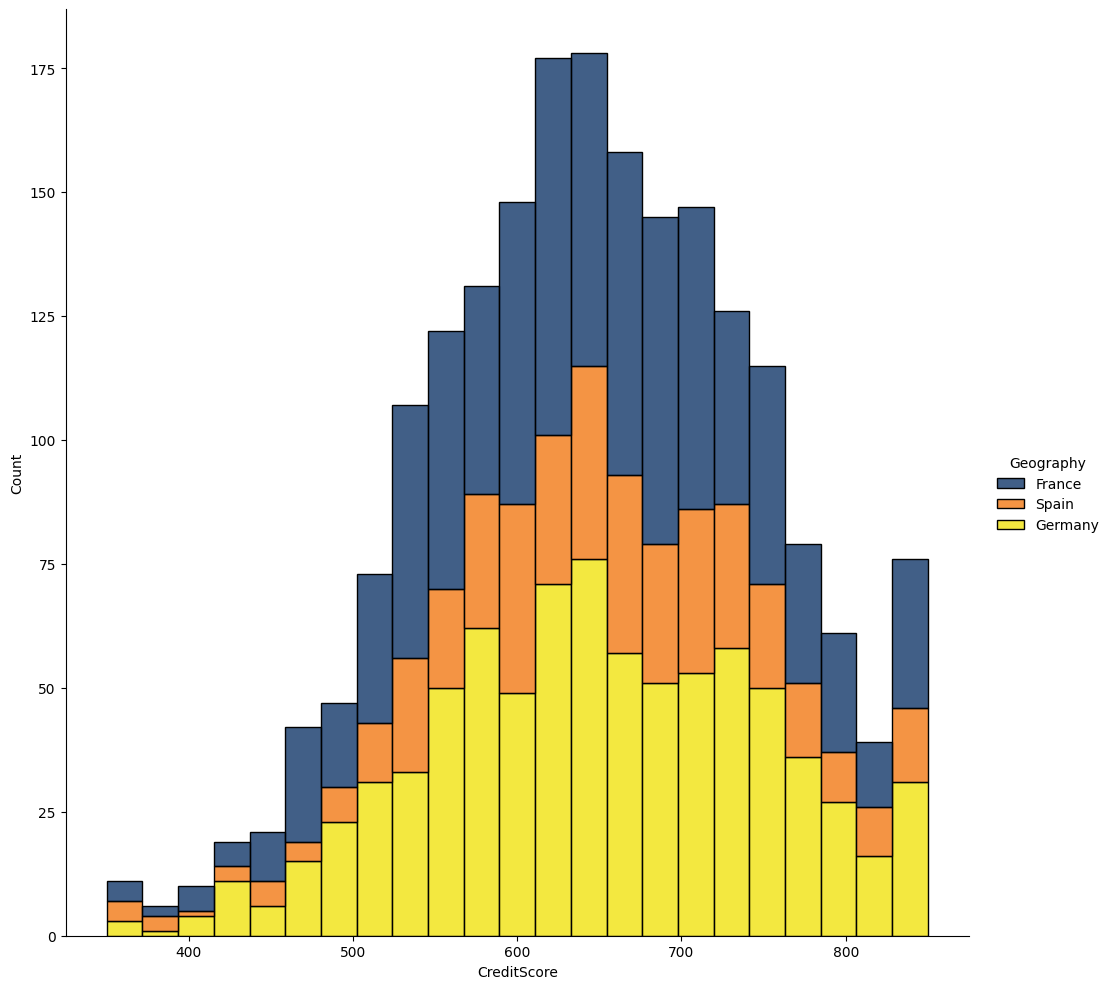

In [14]:
sns.displot(data= churners, x= 'Age', hue= 'Geography', kde= True, height= 7, palette= palette)
sns.displot(data= nonchurners, x= 'Age', hue= 'Geography', kde= True, height= 10, palette= palette)

sns.displot(df, x= 'EstimatedSalary', hue= 'Exited', multiple= 'stack', height= 10)
sns.displot(churners, x= 'CreditScore', hue= 'Geography', multiple= 'stack', height= 10, palette= palette)

In [15]:
balance_df = pd.DataFrame(df['Exited'].value_counts(normalize= False))
balance_df = balance_df.reset_index().rename(columns= {'index':'Exited','Count':'Exited'})
balance_df

,Exited,count
0,0,7962
1,1,2038


In [16]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [17]:
le = LabelEncoder()

df['Geography'] = le.fit_transform(df['Geography'])

le_geography_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [18]:
x = df.drop("Exited", axis= 1)
y = df['Exited']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.25, random_state= 42)


In [19]:
# XGBoost
xgb_churn = xgb.XGBClassifier(gamma= 1.0, learning_rate= 0.15, max_depth= 7, n_estimators= 100)

xgb_churn.fit(x_train, y_train)
y_pred = xgb_churn.predict(x_test)

accuracy_xgb = accuracy_score(y_test, y_pred) * 100
print("The accuracy score of the XGBoost Classification Model is: ", accuracy_xgb)

The accuracy score of the XGBoost Classification Model is:  99.88


In [20]:
# Random Forest

# For this algorithm, it is essential to scale the data.
sc = StandardScaler()
x_rf_train = sc.fit_transform(x_train)
x_rf_test = sc.transform(x_test)

rf = RandomForestClassifier(criterion= 'gini', n_estimators= 100, random_state= 42, max_features= 'auto')
rf.fit(x_rf_train, y_train)

# Evaluating on training set
rf_pred_train = rf.predict(x_rf_train)

# Evaluating on test set
rf_pred_test = rf.predict(x_rf_test)

confusion_matrix(y_test, rf_pred_test)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



array([[2001,    2],
       [   1,  496]])

In [21]:
accuracy_rf = accuracy_score(y_test, rf_pred_test) * 100
print("The accuracy score of the Random Forest Classification Model is: ", accuracy_rf)

The accuracy score of the Random Forest Classification Model is:  99.88


In [22]:
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2003
           1       1.00      1.00      1.00       497

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

